## Notebook for QM0007 Coursework 3: Written Investigation 

This notebook runs a hierarchchical clustering procedure on COVID-19 vaccine uptake data using a DTW distance matrix

Note: I have not been able to install the fast version of dtaidistance so the calculation of the distance matrix is very slow (10 minutes). To run the workbook: restart the workbook, which will run to line 25.
Lines 26 needs to be run by itself to generate the matrix then lines 27--29 can be run. Trying to run the whole workbook at once causes lines 25 onwards to hang.


### Contents

[1. Install and load the required libraries](#1) </br>
[2. Import the datasets and save locally](#2) </br>
[3. Data preparation](#3) </br>
[4. Hierarchical clustering of vaccine uptake in the first 100 days](#4) </br>

### 1. Install and load the required libraries <a class="anchor" id="1"></a>

In [1]:
# install the dtaidistance library 
!pip install dtaidistance | grep -v 'already satisfied'

In [2]:
# downloading and storing data 
import os
import requests 
import zipfile

# data cleaning
import re
import datetime

# data analysis
import numpy as np
import pandas as pd
import geopandas as gpd
import random
from random import sample

# DTW
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

# cluster analysis
import scipy
#import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#from scipy.cluster.hierarchy import fcluster

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


### 2. Import the datasets and save locally <a class="anchor" id="2">

#### 2.1. Function to access raw data and store locally 

- This is a piece of code that I have used in previous work 

- The function accesses raw data from a list of URLs provided to it and stores it locally

- The function takes two arguments as strings: <br/>
  (a) the name of the folder in which to store the data locally and <br/>
  (b) the url from which the data can be fetched remotely



In [3]:
def get_data(folder, url):
    
    # specify the root from which the file path will be created
    cwd = os.getcwd()
    # specify the part of the url string to extract as a filename 
    file_name = url.split("/")[-1]
    # obtain the file extension for use when dealing with .zip files
    extn = url.split(".")[-1]
    
    # check if the file path already exists, in which case there's nothing to do 
    if os.path.exists(os.path.join(cwd, folder, file_name)):
        print(f"the path {os.path.join(cwd, folder, file_name)} exists")
    
    # in the case where the data doesn't exist locally:
    # on the first ever pass, the folder for storing the data won't exist so will need to be created
    else:
        if os.path.exists(os.path.join(cwd, folder)) == False:
            os.makedirs(folder)
    
    # access the data from the remote location and make a copy of it in the destination folder 
        r = requests.get(url + "?raw=true")
        with open(os.path.join(os.getcwd(), folder, file_name), "wb") as file:
                file.write(r.content)
    
    # if the file has a .zip extension, unzip it in the destination folder
    # .zip folder can be removed once contents unzipped but I decided to retain it in this
    # case so that the line testing the existence of the file paths will work in the case of zip files
        if extn == "zip":
            with zipfile.ZipFile(os.path.join(os.getcwd(), folder, file_name)) as z:
                z.extractall(os.path.join(cwd, folder))
                #os.remove(os.path.join(os.getcwd(), folder, file_name))
        
    return

#### 2.2 Description of the datasets

1. **utla_daily_first_dose.csv**: data on the number of first dose COVID-19 vaccinations by day delivered in each upper tier local authority in England, Wales and Scotland beween 8 Dec 2020 and 8 Dec 2021. Data originally from: https://coronavirus.data.gov.uk/details/download 
2. **ew_ethnic_pop.csv**: estimates of the ethnic minority populations of England and Wales by local authority, based on the data and ethnicity classifications in the 2011 census. Data originally from: https://data.gov.uk/dataset/ff9cec02-c9d0-49ad-a491-fb734932524b/regional-ethnic-diversity-in-england-and-wales
3. **local_authority_imd_summaries_2019.xlsx**: data from the 2019 indices of multiple deprivation, summarised at local authority level. Data originally from: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019
4. **local_authority_boundaries_may2021.zip** file containing the local authority boundaries for the United Kingdom. Data originally from: https://geoportal.statistics.gov.uk/maps/counties-and-unitary-authorities-december-2017-boundaries-gb/explore


#### 2.3 Access data and store locally

In [4]:
# run the get_data function over all of the data sources in the list
data = ["https://github.com/MissMaya/casa0007_cwk3/blob/master/utla_daily_first_dose.csv",
        "https://github.com/MissMaya/casa0007_cwk3/blob/master/ew_ethnic_pop.csv",
        "https://github.com/MissMaya/casa0007_cwk3/blob/master/local_authority_imd_summaries_2019.xlsx",
        "https://github.com/MissMaya/casa0007_cwk3/blob/master/local_authority_boundaries_may2021.zip"]

for d in data:
    get_data("data_raw", d)

the path /home/jovyan/work/CASA0007_QM/QM_CW_3/data_raw/utla_daily_first_dose.csv exists
the path /home/jovyan/work/CASA0007_QM/QM_CW_3/data_raw/ew_ethnic_pop.csv exists
the path /home/jovyan/work/CASA0007_QM/QM_CW_3/data_raw/local_authority_imd_summaries_2019.xlsx exists
the path /home/jovyan/work/CASA0007_QM/QM_CW_3/data_raw/local_authority_boundaries_may2021.zip exists


### 3. Data preparation <a class="anchor" id="3">

#### 3.1 Get the data frame into the correct format

In [5]:
# load the daily doses data
doses = pd.read_csv("data_raw/utla_daily_first_dose.csv", low_memory=False)

In [6]:
# examining the first few rows of the data shows that the data is not in the correct 
# format for clustering
# require one time series of daily first doses per upper tier local authority ("utla")
doses.head()

,areaCode,areaName,areaType,date,newPeopleVaccinatedFirstDoseByVaccinationDate
0,E06000003,Redcar and Cleveland,utla,2022-01-18,19
1,E06000014,York,utla,2022-01-18,187
2,E06000050,Cheshire West and Chester,utla,2022-01-18,54
3,E08000001,Bolton,utla,2022-01-18,52
4,E08000016,Barnsley,utla,2022-01-18,59


In [7]:
# check the column types to see whether the date column will need to be converted to 
# type datetime
doses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73658 entries, 0 to 73657
Data columns (total 5 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   areaCode                                       73658 non-null  object
 1   areaName                                       73658 non-null  object
 2   areaType                                       73658 non-null  object
 3   date                                           73658 non-null  object
 4   newPeopleVaccinatedFirstDoseByVaccinationDate  73658 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.8+ MB


In [8]:
# change the column names to easier to read labels
doses.rename(columns = {"areaCode":"area_code",
                        "areaName":"area_name",
                        "newPeopleVaccinatedFirstDoseByVaccinationDate":"new_first_doses"}, 
                        inplace = True)

In [9]:
# drop the "areaType" column as it is redundant
doses.drop(["areaType"], axis = 1);

In [10]:
# pivot columns to give a date index and first doses by area as columns
# this is to make datframe easier to read and for plotting
# will need to use a transpose of the eventual dataframe for the clustering
doses_pivot = doses.pivot(index = "date", columns = "area_name", values = "new_first_doses")

In [11]:
# convert the pivot table to a dataframe
daily_first_doses = doses_pivot.reset_index()

In [12]:
daily_first_doses.head()

area_name,date,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Barking and Dagenham,Barnet,Barnsley,Bath and North East Somerset,Bedford,...,West Sussex,Westminster,Wigan,Wiltshire,Windsor and Maidenhead,Wirral,Wokingham,Wolverhampton,Worcestershire,York
0,2020-12-08,13.0,18.0,16.0,1.0,1.0,23.0,15.0,5.0,3.0,...,109.0,9.0,9.0,4.0,24.0,126.0,9.0,3.0,7.0,1.0
1,2020-12-09,6.0,2.0,32.0,4.0,0.0,49.0,26.0,3.0,6.0,...,102.0,26.0,18.0,10.0,14.0,236.0,15.0,16.0,13.0,1.0
2,2020-12-10,83.0,43.0,81.0,5.0,3.0,63.0,8.0,6.0,9.0,...,89.0,30.0,23.0,18.0,30.0,267.0,14.0,23.0,6.0,4.0
3,2020-12-11,130.0,64.0,90.0,77.0,3.0,84.0,10.0,8.0,10.0,...,103.0,28.0,22.0,34.0,40.0,278.0,8.0,60.0,28.0,6.0
4,2020-12-12,4.0,2.0,57.0,4.0,7.0,22.0,20.0,29.0,9.0,...,93.0,7.0,17.0,76.0,4.0,167.0,8.0,57.0,30.0,0.0


#### 3.2 Obtain 100 day's worth of data

In [13]:
min(daily_first_doses["date"])

'2020-12-08'

In [14]:
# convert the type of the datetime column to datetime
daily_first_doses["date"] = daily_first_doses["date"].astype("datetime64[ns]")

In [15]:
# analysis will look at the first 100 days of data to match the OpenSAFELY study 

from datetime import timedelta

# the start date is the first date in the time series: 8 Dec 2020, which is the date that the first COVID
# vaccination was delivered in the UK
start_date = min(daily_first_doses["date"])

# the end date is the date falling 100 days after the start date
# this is 17 Mar 2021
end_date = start_date + timedelta(days = 99)

# then filter for dates falling withn 100 days of the date of the first record
date_mask = (daily_first_doses["date"] <= end_date)

daily_first_doses = daily_first_doses.loc[date_mask]

In [16]:
# check series length is as expected
len(daily_first_doses)

100

#### 3.3 Check for and treat duplicated and null values

In [17]:
# check that dates do not contain duplicates
daily_first_doses["date"].duplicated().sum()

0

In [18]:
# check data frame for null values
pd.set_option("display.max_rows", None)
daily_first_doses.isnull().sum().sort_values(ascending = False)

area_name
Na h-Eileanan Siar                     2
Luton                                  1
Calderdale                             1
Torbay                                 1
North East Lincolnshire                1
Knowsley                               1
Kingston upon Hull, City of            1
Shetland Islands                       1
Sandwell                               0
Redcar and Cleveland                   0
Peterborough                           0
Sheffield                              0
Plymouth                               0
Portsmouth                             0
Reading                                0
Redbridge                              0
Renfrewshire                           0
Salford                                0
Richmond upon Thames                   0
Rochdale                               0
Oxfordshire                            0
Sefton                                 0
Rotherham                              0
Scottish Borders                       0
Rutlan

In [19]:
# 9 instances of null entries in whole dataset, which is a small number 

# Use 0 in this instance to fill in for null
daily_first_doses = daily_first_doses.fillna(0);

#### 3.4 Exploratory plots

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

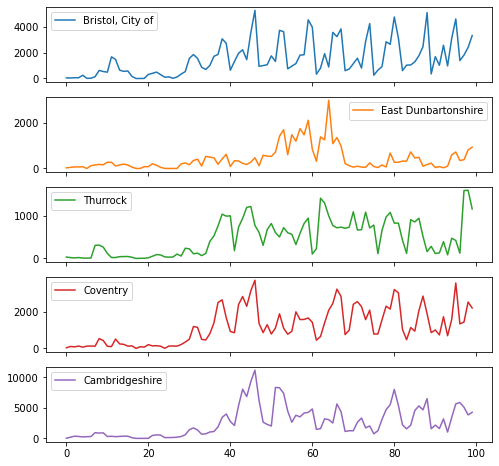

In [20]:
# examine a random sample of plots to visually inspect the differences between series

random_utla = daily_first_doses.sample(n = 5, axis='columns', random_state = 50)

random_utla.plot(figsize = (8,8),
                 subplots = True,
                 )

# differing shapes of plots of vaccine uptake over the year and scale of the uptake are clearly evident

### 4. Hierarchical clustering of vaccine uptake in the first 100 days <a class="anchor" id="4">

#### 4.1 Set up and scale dataframe for clustering

In [21]:
# Make a new data frame of first dose data, excluding the date column

daily_fd = daily_first_doses.iloc[:,1:]

In [22]:
daily_fd.head()

area_name,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Barking and Dagenham,Barnet,Barnsley,Bath and North East Somerset,Bedford,Bexley,...,West Sussex,Westminster,Wigan,Wiltshire,Windsor and Maidenhead,Wirral,Wokingham,Wolverhampton,Worcestershire,York
0,13.0,18.0,16.0,1.0,1.0,23.0,15.0,5.0,3.0,12.0,...,109.0,9.0,9.0,4.0,24.0,126.0,9.0,3.0,7.0,1.0
1,6.0,2.0,32.0,4.0,0.0,49.0,26.0,3.0,6.0,17.0,...,102.0,26.0,18.0,10.0,14.0,236.0,15.0,16.0,13.0,1.0
2,83.0,43.0,81.0,5.0,3.0,63.0,8.0,6.0,9.0,43.0,...,89.0,30.0,23.0,18.0,30.0,267.0,14.0,23.0,6.0,4.0
3,130.0,64.0,90.0,77.0,3.0,84.0,10.0,8.0,10.0,37.0,...,103.0,28.0,22.0,34.0,40.0,278.0,8.0,60.0,28.0,6.0
4,4.0,2.0,57.0,4.0,7.0,22.0,20.0,29.0,9.0,48.0,...,93.0,7.0,17.0,76.0,4.0,167.0,8.0,57.0,30.0,0.0


In [23]:
# Daily first doses for upper tier local authorities are used in this analysis
# As upper tier local authorities contain different population sizes
# The differences in scale were evident from the plots in 3.4, above
# normalise data to prevent clustering from splitting larger areas from smaller 

cols = daily_fd.columns
scaler = MinMaxScaler()

daily_fd_scaled = pd.DataFrame(scaler.fit_transform(daily_fd), columns = cols).transpose()

In [24]:
daily_fd_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
area_name,,,,,,,,,,,,,,,,,,,,,
Aberdeen City,0.004829,0.002229,0.030832,0.048291,0.001486,0.001114,0.086553,0.175334,0.147845,0.152675,...,0.417162,0.187221,0.452080,0.421248,0.458767,0.465825,0.237741,0.472511,0.295319,0.694279
Aberdeenshire,0.004479,0.000498,0.010699,0.015924,0.000498,0.000746,0.082110,0.137348,0.100523,0.109978,...,0.357303,0.552127,0.308783,0.297835,0.371237,0.023887,0.151779,0.571535,0.756905,0.548644
Angus,0.006774,0.013548,0.034293,0.038103,0.024132,0.029636,0.038950,0.030906,0.023285,0.018628,...,0.125741,0.250212,0.136749,0.205758,0.209568,0.099915,0.004657,0.078747,0.113887,0.428027
Argyll and Bute,0.000397,0.001587,0.001984,0.030556,0.001587,0.000397,0.009921,0.063889,0.076984,0.120238,...,0.160714,0.194444,0.415476,0.421429,0.257143,1.000000,0.079762,0.045238,0.207143,0.530159
Barking and Dagenham,0.000629,0.000000,0.001887,0.001887,0.004403,0.000000,0.000000,0.120126,0.349057,0.374214,...,0.605660,0.255346,0.306918,0.399371,0.752830,0.710692,0.318868,0.530189,0.474843,0.507547


#### 4.2 Generate the distance matrix using DTW

In [25]:
input_matrix = scaler.fit_transform(daily_fd).transpose()

In [26]:
# dtw_dmatrix = dtw.distance_matrix(input_matrix, compact = True)

In [27]:
# Z_dtw_single = linkage(dtw_dmatrix, "single")
# c_dtw_s, coph_dtw_s = cophenet(Z_dtw_single, pdist(daily_fd_scaled))
# single = round(c_dtw_s * 100, 2)
# print(single)

In [28]:
# Z_dtw_complete = linkage(dtw_dmatrix, "complete")
# c_dtw_c, coph_dtw_c = cophenet(Z_dtw_complete, pdist(daily_fd_scaled))
# complete = round(c_dtw_c * 100, 2)
# print(complete)

In [29]:
# Z_dtw_average = linkage(dtw_dmatrix, "average")
# c_dtw_a, coph_dtw_a = cophenet(Z_dtw_average, pdist(daily_fd_scaled))
# average = round(c_dtw_a * 100, 2)
# print(average)